In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Generating dummy data

In [2]:
# all of this ressembles the kind of data we will get from the Google forms, however, we will for sure need to readapt the code, 
# as everything may not be perfectly as in here

genders = ['M', 'F', 'O'] # male, female, other
section_categories = [
    'comp_science',
    'basic_science',
    'engineering',
    'life_science',
    'civil_engineering',
    'management',
    'humanities'
]
sections_mapping = {
    'Computer Science': 0,
    'Communication Systems': 0,
    'Data Science': 0,
    'Cyber Security': 0,
    'Molecular and Biological Chemistry': 1,
    'Chemical Engineering and Biotechnology': 1,
    'Mathematics': 1,
    'Applied Mathematics': 1,
    'Computational Science': 1,
    'Physics': 1,
    'Applied Physics': 1,
    'Nuclear Engineering': 1,
    'Electrical Engineering': 2,
    'Mechanical Engineering': 2,
    'Microengineering': 2,
    'Robotics': 2,
    'Materials Science and Engineering': 2,
    'Energy Science and Technology': 2,
    'Life Sciences Engineering': 3,
    'Architecture': 4,
    'Civil Engineering': 4,
    'Environmental Sciences and Engineering': 4,
    'Financial Engineering': 5,
    'Management, technology and entrepreneurship': 5,
    'Digital Humanities': 6
}
genres = [
    'Classical',
    'Rock',
    'Pop',
    'R&B and Soul',
    'Electronic',
    'Folk',
    'Jazz',
    'Blues',
    'Hip hop'
]

In [3]:
def random(l):
    '''Returns a random element from l'''
    return l[np.random.randint(len(l))]

In [4]:
def random_row():
    '''Generates a random row as we might get from the Google form'''
    l = []
    
    # basic info
    l.append(np.random.randint(18, 27))
    l.append(random(genders))
    l.append(random(list(sections_mapping.keys())))
    
    # musical taste info
    for i in range(len(genres)):
        # trying to get different distributions between computer science and the others
        if section_categories[sections_mapping[l[2]]] == 'comp_science':
            # l.append((2 * np.abs(np.random.normal(0.5, 0.5) + np.random.normal(4.5, 1.5))) // 1 / 2)
            l.append([2, 3, 0, 0, 2, 3, 7, 1, 2][i])
        else:
            l.append((2 * np.abs(np.random.normal(2, 2))) // 1 / 2)
    
    return l

In [5]:
# writing the dummy data
with open('dummy.csv', 'w') as fp:
    fp.write('"Age","Gender","Section","' + '","'.join(genres) + '"\n')
    for _ in range(100):
        fp.write('"' + '","'.join([str(val) for val in random_row()]) + '"\n')

### As if

In [6]:
data = pd.read_csv('dummy.csv')

In [7]:
data.dtypes

Age               int64
Gender           object
Section          object
Classical       float64
Rock            float64
Pop             float64
R&B and Soul    float64
Electronic      float64
Folk            float64
Jazz            float64
Blues           float64
Hip hop         float64
dtype: object

In [8]:
# Creating a new column 'School' using the mapping defined at the beginning
data['School'] = [section_categories[sections_mapping[val]] for val in data['Section']]

In [9]:
data.head()

,Age,Gender,Section,Classical,Rock,Pop,R&B and Soul,Electronic,Folk,Jazz,Blues,Hip hop,School
0,25,O,Nuclear Engineering,1.5,5.5,2.0,4.0,0.0,1.0,0.5,2.0,0.0,basic_science
1,18,M,Financial Engineering,2.0,4.0,1.0,4.5,3.5,0.5,2.0,2.0,1.0,management
2,22,M,Architecture,1.5,0.0,1.5,4.5,3.0,0.0,1.0,3.5,0.5,civil_engineering
3,25,F,Materials Science and Engineering,2.5,2.5,1.0,1.5,2.0,1.0,0.0,4.5,3.5,engineering
4,21,F,Cyber Security,2.0,3.0,0.0,0.0,2.0,3.0,7.0,1.0,2.0,comp_science


In [10]:
def vectors_per_school(data):
    '''Creates a dictionary with keys being each school, and the values the vector representing the musical taste'''
    vectors_dict = {}
    for school in section_categories:
        vectors_dict[school] = data[data['School'] == school][data.columns[3:-1]].values
        
    return vectors_dict

In [11]:
def binary_vectors(data, school):
    '''Creates two list of vectors, one for the given school, one for all the other'''
    vectors = []
    vectors.append(data[data['School'] == school][data.columns[3:-1]].values)
    vectors.append(data[data['School'] != school][data.columns[3:-1]].values)
    
    return vectors

In [12]:
def cos_sim(vectors_1, vectors_2):
    '''Cosine similarity of 2 vectors. Values close to 1 mean similar vectors'''
    mean_1 = vectors_1.mean(axis=0)
    mean_2 = vectors_2.mean(axis=0)
    
    return mean_1.dot(mean_2) / (np.linalg.norm(mean_1) * np.linalg.norm(mean_2))

In [13]:
def abs_diff(vectors_1, vectors_2):
    '''Sum of absolute difference of 2 vectors. Values close to 0 mean similar vectors'''
    mean_1 = vectors_1.mean(axis=0)
    mean_2 = vectors_2.mean(axis=0)
    
    mean_1 /= np.sum(mean_1)
    mean_2 /= np.sum(mean_2)
    
    return np.sum(np.abs(mean_1 - mean_2))

In [14]:
comp_science_binary = binary_vectors(data, 'comp_science')
# comp_science_binary = binary_vectors(data[data['School'] != 'comp_science'], 'engineering')

In [15]:
cos_sim(comp_science_binary[0], comp_science_binary[1])

0.7330170397301519

In [16]:
abs_diff(comp_science_binary[0], comp_science_binary[1])

0.6276271702710935

In [17]:
def sample_bootstrap(binary_vecs, f=abs_diff, k=1000):
    '''2-sample bootstrap technique'''
    size_1 = binary_vecs[0].shape[0]
    size_2 = binary_vecs[1].shape[0]
    size_total = size_1 + size_2
    
    stacked = np.vstack([binary_vecs[0], binary_vecs[1]])
    
    distances = []
    
    for _ in range(k):
        # randomly picking with replacement
        indices = np.random.choice(range(size_total), size=size_total)
        new = stacked[indices]
        new_1 = new[:size_1]
        new_2 = new[size_1:]
        
        distances.append(f(new_1, new_2))
        
    return distances

In [18]:
true_diff = cos_sim(comp_science_binary[0], comp_science_binary[1]) # true original difference

In [19]:
diffs = sample_bootstrap(comp_science_binary, f=cos_sim) # list of every differences from the 2-sample bootstrap

In [20]:
five, ninety_five = np.percentile(diffs, [5, 95]) # 5 and 95 percentiles

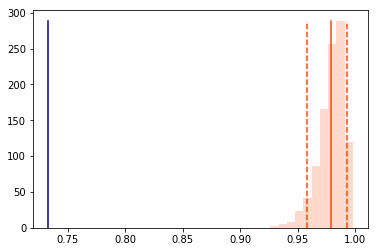

In [21]:
# hist = plt.hist(diffs, bins=np.linspace(0, 1, ), color='r', alpha=0.2)
hist = plt.hist(diffs, color='orangered', alpha=0.2)
max_hist = np.max(hist[0])
plt.plot([true_diff, true_diff], [0, max_hist], color='navy') # blue line
plt.plot([np.mean(diffs), np.mean(diffs)], [0, max_hist], color='orangered') # red line
plt.plot([five, five], [0, max_hist], color='orangered', linestyle='--') # red dashed line
plt.plot([ninety_five, ninety_five], [0, max_hist], color='orangered', linestyle='--') # red dashed line
plt.show()

If the blue line (representing the true difference) is outside of the interval of confidence of the 2-sample bootstrap, then the null hypothesis can be rejected.